In [2]:
import numpy as np
import pandas as pd
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
import category_encoders as ce
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [3]:
base_path = "/Users/saraawad/Desktop/"
#"gs://agriculture-sara/Data sets/Clusters/Modeling/Library/"

In [4]:
def generate_lags_for(df, column, lags_count): 
            for i in range(lags_count):
                lag_name = column + "-" + str(i + 1)
                df[lag_name] = df[column].shift(i + 1)
            return df

def generate_lags(df, lagsForColumns):
        for k in range(len(lagsForColumns)):
            col = lagsForColumns[k]
            if col in df.columns:
                df = generate_lags_for(df, col, 5)
        return df

def get_all_matching_columns(df, keyword):
    return df.filter(like=keyword).columns

def binary_encode_column(df, columnToEncode):
        encoder = ce.BinaryEncoder(cols=[columnToEncode])
        df_encoder = encoder.fit_transform(df[columnToEncode])
        df = pd.concat([df, df_encoder], axis=1)
        return df

def drop_invalid_lags(df):
    '''This function will drop all the lags'''
    ws_list = list(get_all_matching_columns(df, "WS-"))
    rh_list = list(get_all_matching_columns(df, "RH-"))
    ta_list = list(get_all_matching_columns(df, "TA-"))
    g_list = list(get_all_matching_columns(df, "G-"))
    h_list = list(get_all_matching_columns(df, "H-"))
    h_corr_list = list(get_all_matching_columns(df, "H_bowen_corr-"))
    netrad_list = list(get_all_matching_columns(df, "NETRAD-"))
    columns_to_drop = []
    columns_to_drop.extend(ws_list)
    columns_to_drop.extend(rh_list)
    columns_to_drop.extend(ta_list)
    columns_to_drop.extend(g_list)
    columns_to_drop.extend(h_list)
    columns_to_drop.extend(h_corr_list)
    columns_to_drop.extend(netrad_list)
    df = df.drop(columns_to_drop, axis=1) 
    return df

def generate_input_lags(df):
    '''This function generates the lags for the list of input columns'''
    input_columns = []
    if "RH" in df.columns:
        input_columns.append("RH")
    if "TA" in df.columns:
        input_columns.append("TA")
    if "WS" in df.columns:
        input_columns.append("WS") 
    input_columns.extend(["G", "NETRAD"])
    h_corr_name = "H_bowen_corr"
    if (h_corr_name in df.columns):
        input_columns.append(h_corr_name)
    elif "H" in df.columns:
        input_columns.append("H")
        
    print("columns are:", input_columns)
        
    for k in range(len(input_columns)):
        col = input_columns[k]
        if col in df.columns:
            df = generate_lags(df, col, 5)
    return df


<h3> 1. Read Data set </h3>

In [6]:
#Specify the input path of the data set
# input_path = "gs://agriculture-sara/Test_manual.csv"
# input_path =  "gs://agriculture-sara/Data sets/Data sets for Modeling/Version 2/All_Manual_Daily_Albedo_NDVI_LST_Cleaned.csv"
# input_path = "gs://agriculture-sara/Data sets/Data sets for Modeling/Version 2/All_Library_Daily_Albedo_NDVI_LST_Cleaned.csv"
input_path = "/Users/saraawad/Desktop/All_Manual_Daily_Albedo_NDVI_LST_Cleaned.csv"
# input_path = "/Users/saraawad/Workspace/agriculture/Data sets/Daily/All_Library_Daily_Albedo_NDVI_LST_Cleaned.csv"
df = pd.read_csv(input_path, delimiter=',')
df.head()

#Specify columns to drop
# columnsToDrop = ['Date', 'Site Id','Year','Month','Day',
#                  'G','G-1','G-2','G-3','G-4','G-5',
#                  'H', 'H_CORRECTED-1', 'H_CORRECTED-2', 'H_CORRECTED-3', 'H_CORRECTED-4',
#                  'H_CORRECTED-5',
#                  'NETRAD','NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4','NETRAD-5',
#                  'LE', 'LE_CORRECTED(mm)-1', 'LE_CORRECTED(mm)-2', 'LE_CORRECTED(mm)-3', 'LE_CORRECTED(mm)-4',
#                 'LE_CORRECTED(mm)-5']



# columnsToDrop = ['Date','Year','Month','Day','Latitude','Longitude',
#                  'Climate','Vegetation', 'G','G-1','G-2','G-3','G-4','G-5',
#                  'H','H_bowen_corr','H_bowen_corr-1','H_bowen_corr-2','H_bowen_corr-3',
#                  'H_bowen_corr-4','H_bowen_corr-5', 'H_ebr_corr','H_ebr_corr-1','H_ebr_corr-2',
#                  'H_ebr_corr-3','H_ebr_corr-4','H_ebr_corr-5','LE_ebr_corr','LE_ebr_corr(mm)',
#                  'ET_bowen','ET_bowen_corr','LE_bowen_corr(mm)','ET_ebr','ET_ebr_corr',
#                  'ET_ebr_corr(mm)' ,'NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4',
#                  'NETRAD-5','LE','LE_bowen_corr','EToF_bowen','EToF_ebr',
#                  'ETr','ETrF_bowen','ETrF_ebr', 'Climate_1',
#                  'Climate_2','Climate_3', 'Latitude_1',
#                  'Latitude_2','Latitude_3','Latitude_4','Latitude_5','Latitude_6', 'Longitude_1',
#                  'Longitude_2','Longitude_3','Longitude_4','Longitude_5','Longitude_6',
#                  'Elevation(m)_1','Elevation(m)_2','Elevation(m)_3','Elevation(m)_4',
#                  'Elevation(m)_5','Elevation(m)_6', 'NETRAD', 'SW_IN']


# columnsToDrop = ['Year','Month','Day', 'Latitude','Longitude',
#                  'Vegetation', 'G','G-1','G-2','G-3','G-4','G-5',
#                  'H','H_bowen_corr','H_bowen_corr-1','H_bowen_corr-2','H_bowen_corr-3',
#                  'H_bowen_corr-4','H_bowen_corr-5', 'H_ebr_corr','H_ebr_corr-1','H_ebr_corr-2',
#                  'H_ebr_corr-3','H_ebr_corr-4','H_ebr_corr-5','LE_ebr_corr','LE_ebr_corr(mm)',
#                  'ET_bowen','ET_bowen_corr','ET_bowen_corr(mm)','ET_ebr','ET_ebr_corr',
#                  'ET_ebr_corr(mm)' ,'NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4',
#                  'NETRAD-5','LE','LE_bowen_corr','EToF_bowen','EToF_ebr',
#                  'ETr','ETrF_bowen','ETrF_ebr', 'Climate_1', 'ETo',
#                  'Climate_2','Climate_3', 'Latitude_1',
#                  'Latitude_2','Latitude_3','Latitude_4','Latitude_5','Latitude_6', 'Longitude_1',
#                  'Longitude_2','Longitude_3','Longitude_4','Longitude_5','Longitude_6',
#                  'Elevation(m)_1','Elevation(m)_2','Elevation(m)_3','Elevation(m)_4',
#                  'Elevation(m)_5','Elevation(m)_6', 'NETRAD', 'SW_IN']

columnsToDrop = ['Site Id_1', 'Site Id_2', 'Site Id_3',
                        'Site Id_4', 'Site Id_5', 'Site Id_6',
                        'G','G-1','G-2','G-3','G-4','G-5',
                        'Climate_1', 'Climate_2', 'Climate_3',
                        'Latitude_1','Latitude_2', 'Latitude_3', 'Latitude_4', 'Latitude_5',
                        'Latitude_6','Longitude_1', 'Longitude_2', 'Longitude_3', 'Longitude_4',
                        'Longitude_5', 'Longitude_6',
                        'H', 'H_bowen_corr', 'H_bowen_corr-1', 'H_bowen_corr-2', 'H_bowen_corr-3', 'H_bowen_corr-4',
                        'H_bowen_corr-5', 'C_BOWENS',
                        'NETRAD','NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4','NETRAD-5',
                        'LE', 'LE_bowen_corr',
                        'Elevation(m)_1','Elevation(m)_2', 'Elevation(m)_3', 'Elevation(m)_4',
                        'Elevation(m)_5', 'Elevation(m)_6',
                        'ETo', 'EToF', 'ETr', 'ETrF', 'ETo', 'SW_IN']
#         columnsToDrop = ['Cluster']

df = df.drop(columnsToDrop, axis = 1)

df.dropna(inplace=True)
#Specify the output column
output_column = "LE_bowen_corr(mm)"

df = df[df[output_column].between(1, 15)]

#Generate 5 lags
lagsForColumns = ["SW_IN", "WS", "RH", "TA", "EEflux LST", "EEflux Albedo", "EEflux NDVI"]
df = generate_lags(df, lagsForColumns)
df.dropna(inplace=True)
        

#Binary Encode Site Id
df = binary_encode_column(df, "Site Id")
df.drop(columns=['Site Id_0'], inplace=True)

#Drop NaN values
# df.dropna(inplace=True)
df_original = df

<h3> 2. Compute the average of certain columns </h3>

In [7]:
def get_matching_columns(keyword):
    '''
    This function will get all matching columns with the keyword being sent
    '''
    return [col for col in df.columns if keyword in col]

rh_columns = get_matching_columns("RH-")
ws_columns = get_matching_columns("WS-")
ta_columns = get_matching_columns("TA-")

#Compute the average for the lags of RH, WS, and TA
df['RH_avg'] = df[rh_columns].mean(axis=1)
df['WS_avg'] = df[ws_columns].mean(axis=1)
df['TA_avg'] = df[ta_columns].mean(axis=1)

print(rh_columns, ws_columns, ta_columns)
print(df.columns)

['RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5'] ['WS-1', 'WS-2', 'WS-3', 'WS-4', 'WS-5'] ['TA-1', 'TA-2', 'TA-3', 'TA-4', 'TA-5']
Index(['Date', 'Site Id', 'Year', 'Month', 'Day', 'Climate', 'Vegetation',
       'Latitude', 'Longitude', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Vegetation_1', 'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1', 'WS-2',
       'WS-3', 'WS-4', 'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5',
       'TA', 'TA-1', 'TA-2', 'TA-3', 'TA-4', 'TA-5', 'LE_bowen_corr(mm)',
       'EEflux LST', 'EEflux LST-1', 'EEflux LST-2', 'EEflux LST-3',
       'EEflux LST-4', 'EEflux LST-5', 'EEflux NDVI', 'EEflux NDVI-1',
       'EEflux NDVI-2', 'EEflux NDVI-3', 'EEflux NDVI-4', 'EEflux NDVI-5',
       'EEflux Albedo', 'EEflux Albedo-1', 'EEflux Albedo-2',
       'EEflux Albedo-3', 'EEflux Albedo-4', 'EEflux Albedo-5', 'Site Id_1',
       'Site Id_2', 'Site Id_3', 'Site Id_4', 'Site Id_5', 'RH_avg', 'WS_avg',
       'TA_avg'],
      dtype='object')


<h3> 3. Specify the columns to study </h3>

In [8]:
#Visualize the data set having the weather parameters, their average, and the output column
df_full = df[["RH", "WS", "TA", "RH_avg", "WS_avg", "TA_avg", output_column]]
df_full.head()

RH        WS         TA     RH_avg    WS_avg     TA_avg  \
15  61.889063  4.187396  11.582604  54.798056  3.079181   6.446752   
16  62.385854  3.264042  12.089688  55.479462  3.606527   8.313958   
17  67.020333  2.765604  10.656854  55.362775  3.673239   9.249562   
18  66.779911  5.179489  10.264467  57.011971  3.376614   9.747508   
19  60.416333  4.097194   9.667361  60.721603  3.580545  10.365088   

    LE_bowen_corr(mm)  
15           3.936808  
16           2.447184  
17           1.652518  
18           2.011652  
19           1.748287

<h3> 4. Split the data into input and ouput features </h3>

In [9]:
X = df_full.drop([output_column], axis = 1)
Y = df_full[output_column]
print(X.shape, Y.shape)

(10911, 6) (10911,)


In [10]:
print(df_full.isna().sum())
df_full.describe()

RH                   0
WS                   0
TA                   0
RH_avg               0
WS_avg               0
TA_avg               0
LE_bowen_corr(mm)    0
dtype: int64


RH            WS            TA        RH_avg        WS_avg  \
count  10911.000000  10911.000000  10911.000000  10911.000000  10911.000000   
mean      61.642752      3.003907     18.073222     61.638516      3.003788   
std       13.928438      1.560441      7.134685     11.297496      1.218272   
min        3.083333      0.000000     -9.680565     16.093732      0.568000   
25%       52.845052      1.813753     13.483597     54.468030      2.040263   
50%       62.907813      2.622292     18.792979     62.057714      2.757792   
75%       71.488480      3.930969     23.051667     69.166882      3.865343   
max      103.760761     12.518130     35.706667     91.909458      7.472002   

             TA_avg  LE_bowen_corr(mm)  
count  10911.000000       10911.000000  
mean      18.073488           3.747155  
std        6.613635           1.995136  
min       -5.450327           1.001279  
25%       13.665479           2.141130  
50%       18.731167           3.436059  
75%       22.530585           4.963283  
max       34.714146          14.961610

In [14]:
# wcss = []
# for i in range(1, 11):
#     kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
#     kmeans.fit(X_normalized)
#     wcss.append(kmeans.inertia_)
# plt.plot(range(1, 11), wcss)
# plt.title('Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')
# plt.show()


In [11]:
# columns = ["WS", "TA", "RH"]
columns = ["TA"]
#For scaled version
# scaler = MinMaxScaler((0,1))
# X_scaled = scaler.fit_transform(X)
# # Converting the numpy array into a pandas DataFrame 
# X_normalized = pd.DataFrame(X_scaled, columns=X.columns) 
# X_normalized = X_normalized[columns]

# or for unscaled version
X_normalized = X[columns]

In [12]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X_normalized)

In [13]:
print(kmeans.cluster_centers_)

[[25.64837027]
 [ 8.09033212]
 [17.69155114]]


In [18]:
# plt.scatter(X_normalized["TA"], X_normalized["RH"], c=pred_y, cmap='viridis')
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=70, c='red')
# plt.show()

In [14]:
print(kmeans.labels_)
print(Counter(kmeans.labels_))

[1 1 1 ... 1 1 1]
Counter({2: 4837, 0: 3551, 1: 2523})


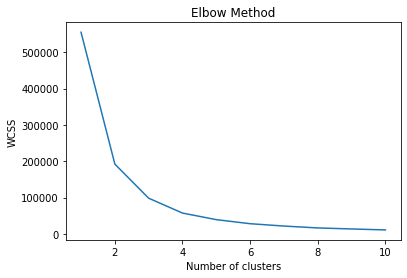

In [22]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_normalized)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

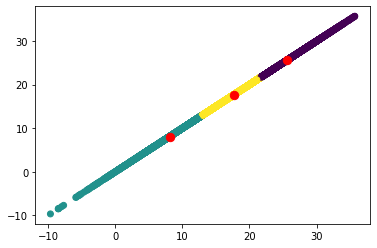

In [24]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X_normalized[columns])
plt.scatter(X_normalized[columns[0]], X_normalized[columns[0]], c=pred_y, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,0], s=70, c='red')
plt.show()

In [15]:
df_original["Cluster"] = kmeans.labels_

In [16]:
unique_clusters = df_original["Cluster"].unique()
print(unique_clusters)

[1 2 0]


In [17]:
def generate_lags(df, column, lags_count): 
    for i in range(lags_count):
        lag_name = column + "-" + str(i + 1)
        df[lag_name] = df[column].shift(i + 1)
    return df

def get_all_matching_columns(df, keyword):
    return df.filter(like=keyword).columns

def binary_encode_column(self, df, columnToEncode):
        encoder = ce.BinaryEncoder(cols=[columnToEncode])
        df_encoder = encoder.fit_transform(df[columnToEncode])
        df = pd.concat([df, df_encoder], axis=1)
        return df

def drop_invalid_lags(df):
    '''This function will drop all the lags'''
    ws_list = list(get_all_matching_columns(df, "WS-"))
    rh_list = list(get_all_matching_columns(df, "RH-"))
    ta_list = list(get_all_matching_columns(df, "TA-"))
    g_list = list(get_all_matching_columns(df, "G-"))
    h_list = list(get_all_matching_columns(df, "H-"))
    h_corr_list = list(get_all_matching_columns(df, "H_bowen_corr-"))
    netrad_list = list(get_all_matching_columns(df, "NETRAD-"))
    columns_to_drop = []
    columns_to_drop.extend(ws_list)
    columns_to_drop.extend(rh_list)
    columns_to_drop.extend(ta_list)
    columns_to_drop.extend(g_list)
    columns_to_drop.extend(h_list)
    columns_to_drop.extend(h_corr_list)
    columns_to_drop.extend(netrad_list)
    df = df.drop(columns_to_drop, axis=1) 
    return df

def generate_input_lags(df):
    '''This function generates the lags for the list of input columns'''
    input_columns = []
    if "RH" in df.columns:
        input_columns.append("RH")
    if "TA" in df.columns:
        input_columns.append("TA")
    if "WS" in df.columns:
        input_columns.append("WS") 
    input_columns.extend(["G", "NETRAD"])
    h_corr_name = "H_bowen_corr"
    if (h_corr_name in df.columns):
        input_columns.append(h_corr_name)
    elif "H" in df.columns:
        input_columns.append("H")
        
    print("columns are:", input_columns)
        
    for k in range(len(input_columns)):
        col = input_columns[k]
        if col in df.columns:
            df = generate_lags(df, col, 5)
    return df


In [18]:
print("Cluster 0:")
print("TA:")
print(df_original[df_original["Cluster"] == 0]["TA"].min())
print(df_original[df_original["Cluster"] == 0]["TA"].max())
print("RH:")
print(df_original[df_original["Cluster"] == 0]["RH"].min())
print(df_original[df_original["Cluster"] == 0]["RH"].max())

print("Cluster 1:")
print("TA:")
print(df_original[df_original["Cluster"] == 1]["TA"].min())
print(df_original[df_original["Cluster"] == 1]["TA"].max())
print("RH:")
print(df_original[df_original["Cluster"] == 1]["RH"].min())
print(df_original[df_original["Cluster"] == 1]["RH"].max())


print("Cluster 2:")
print("TA:")
print(df_original[df_original["Cluster"] == 2]["TA"].min())
print(df_original[df_original["Cluster"] == 2]["TA"].max())
print("RH:")
print(df_original[df_original["Cluster"] == 2]["RH"].min())
print(df_original[df_original["Cluster"] == 2]["RH"].max())

Cluster 0:
TA:
21.670625
35.706666666666656
RH:
13.114468085106385
95.07516666666668
Cluster 1:
TA:
-9.680565217391305
12.887395833333333
RH:
3.083333333333334
103.7607611125
Cluster 2:
TA:
12.892976190476196
21.66933333333333
RH:
4.7125
95.45238095238098


In [24]:
df_original = drop_invalid_lags(df_original)
cluster_num = 3
algorithm_name = "Kmeans/3/"
algorithm_name = "Kmeans/"
# parameter_name = "WS_TA_RH_Cluster_"
parameter_name = "TA_Cluster_"
for i in range(len(unique_clusters)):
    cluster = unique_clusters[i]
    df_sub = df_original[df_original["Cluster"] == cluster]
    df_sub = generate_input_lags(df_sub)
    file_path = os.path.join(base_path, algorithm_name)
    print(file_path)
    export_path = os.path.join(file_path, "kmeans_" + parameter_name + str(cluster) + ".csv")
    export_csv = df_sub.to_csv(export_path, index=None, header=True)  
    

columns are: ['RH', 'TA', 'WS', 'G', 'NETRAD']
/Users/saraawad/Desktop/Kmeans/
columns are: ['RH', 'TA', 'WS', 'G', 'NETRAD']
/Users/saraawad/Desktop/Kmeans/
columns are: ['RH', 'TA', 'WS', 'G', 'NETRAD']
/Users/saraawad/Desktop/Kmeans/


In [53]:
print(df_original[df_original["Cluster"] == 0]["WS"].min())
print(df_original[df_original["Cluster"] == 0]["WS"].max())

0.05166666666666666
12.518130434782607


In [312]:
print(df_original[df_original["Cluster"] == 1]["WS"].min())
print(df_original[df_original["Cluster"] == 1]["WS"].max())

6.1122258060000005
12.714425


In [313]:
print(df_original[df_original["Cluster"] == 2]["WS"].min())
print(df_original[df_original["Cluster"] == 2]["WS"].max())

2.3348675
3.955310604


In [314]:
print(df_original[df_original["Cluster"] == 3]["WS"].min())
print(df_original[df_original["Cluster"] == 3]["WS"].max())

3.957107143
6.10893617


## Dendograms

In [19]:
columns = ["TA"]
#For scaled version
# scaler = MinMaxScaler((0,1))
# X_scaled = scaler.fit_transform(X)
# # Converting the numpy array into a pandas DataFrame 
# X_normalized = pd.DataFrame(X_scaled, columns=X.columns) 
# X_normalized = X_normalized[columns]
# or for unscaled version
X_normalized = X[columns]

In [20]:
from sklearn.cluster import AgglomerativeClustering
ahc_model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
ahc_model.fit_predict(X_normalized)

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_normalized, method='ward'))

In [26]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_normalized, method='ward'))
#Specify the horizontal line(threshold) based on the maximum vertical distance to 
#have more separable clusters
plt.axhline(y=12.5, color='r', linestyle='--')

In [21]:
df_original["Cluster"] = ahc_model.labels_
unique_clusters = df_original["Cluster"].unique()

In [724]:
df_original = drop_invalid_lags(df_original)
algorithm_name = "Dendograms-AHC/k4/Unscaled/TwoColumns/"
parameter_name = "WS_TA_Cluster_"
# parameter_name = "WS_TA_RH_Cluster_"

for i in range(len(unique_clusters)):
    cluster = unique_clusters[i]
    df_sub = df_original[df_original["Cluster"] == cluster]
    df_sub = generate_input_lags(df_sub)
    file_path = os.path.join(base_path, algorithm_name)
    print(file_path)
    export_path = os.path.join(file_path, "AHC_" + parameter_name + str(cluster) + ".csv")
    export_csv = df_sub.to_csv(export_path, index=None, header=True)

columns are: ['RH', 'TA', 'WS', 'G', 'NETRAD', 'H']
gs://agriculture-sara/Data sets/Clusters/Dendograms-AHC/k4/Unscaled/TwoColumns/
columns are: ['RH', 'TA', 'WS', 'G', 'NETRAD', 'H']
gs://agriculture-sara/Data sets/Clusters/Dendograms-AHC/k4/Unscaled/TwoColumns/
columns are: ['RH', 'TA', 'WS', 'G', 'NETRAD', 'H']
gs://agriculture-sara/Data sets/Clusters/Dendograms-AHC/k4/Unscaled/TwoColumns/
columns are: ['RH', 'TA', 'WS', 'G', 'NETRAD', 'H']
gs://agriculture-sara/Data sets/Clusters/Dendograms-AHC/k4/Unscaled/TwoColumns/


In [560]:
print(df_original[df_original["Cluster"] == 0]["WS"].min())
print(df_original[df_original["Cluster"] == 0]["WS"].max())

print(df_original[df_original["Cluster"] == 1]["WS"].min())
print(df_original[df_original["Cluster"] == 1]["WS"].max())

0.0
4.255722222
4.257083333
12.714425
